In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    # "SP Donor A"
]


In [6]:
adata_path = data_dir / "metadata" / f"combined_final.h5ad"


# Import data

In [7]:
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries


def get_imgs(file_path, name):
    f = h5py.File(file_path, "r")
    imgs = f[name]
    labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    return exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 1))


# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity", "area"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.drop("area", axis=1, inplace=True)

    df_prop["mean_intensity"] = np.arcsinh(df_prop[["mean_intensity"]])

    return df_prop

def get_img_subset(imgs, marker):
    imgs_subset = []
    for marker in markers:
        idx = labels.index(marker)
        imgs_subset.append(imgs[idx][:1000,:1000])
    return imgs_subset

In [8]:
markers = [
    "CD38",
    "Vimentin",
    "CD21",
    "BCL6",
    "ICOS1",
    "CD11b",
    'CXCR4',
    "CD11c",
    "FoxP3",
    "CD4",
    "CD138",
    "CXCR5",
    "CD20",
    "CD8",
    "C-Myc",
    "PD1",
    "CD83",
    "Ki67",
    "COL1",
    "CD3",
    "CD27",
    "EZH2",
    "H3K27me3",
]
df_all = []
centroids = []

In [9]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [10]:
for donor in donors:
    h5_data = p_dir / "data" / "h5_new" / f"{donor}.hdf5"
    df = pd.read_csv(data_dir / "metadata" / f"info_{donor}.csv")
    ROIs = df.ROI.unique()
    masks = get_masks(data_dir / "masks" / donor)

    for roi in tqdm(ROIs, total=len(ROIs)):
        if roi not in arrangement[donor].keys():
            continue
        imgs, labels = get_imgs(h5_data, str(roi))
        mask = masks[str(roi)]

        imgs = get_img_subset(imgs, markers)

        df_appended_list = []
        for i, img in enumerate(imgs):
            df_prop = read_intensity_per_cell(img, mask)
            df_prop.columns = ["Cell_label", markers[i]]
            df_appended_list.append(df_prop)

        # Combine dataframe
        df_cell_intensity = reduce(
            lambda left, right: pd.merge(left, right, on=["Cell_label"]),
            df_appended_list,
        )
        df_cell_intensity["ROI"] = roi
        df_cell_intensity["Donor"] = donor
        df_all.append(df_cell_intensity)

        props = skimage.measure.regionprops_table(
            mask, properties=["label", "centroid"]
        )
        rows = props["centroid-0"] + arrangement[donor][roi][0]
        cols = props["centroid-1"] + arrangement[donor][roi][1]
        centroid = np.array(list(zip(cols, rows)))
        centroids.append(centroid)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [11]:
centroids = np.concatenate(centroids)

In [12]:
df = pd.concat(df_all, ignore_index=True)
df.head()

,Cell_label,CD38,Vimentin,CD21,BCL6,ICOS1,CD11b,CXCR4,CD11c,FoxP3,...,PD1,CD83,Ki67,COL1,CD3,CD27,EZH2,H3K27me3,ROI,Donor
0,1,0.000000,3.550442,0.174119,0.0,0.000000,0.000000,0.0,0.898941,0.0,...,0.0,0.0,0.0,1.951893,0.00000,0.0,0.0,4.380307,1,LN Donor A
1,2,0.000000,3.930668,0.000000,0.0,0.000000,0.000000,0.0,0.808032,0.0,...,0.0,0.0,0.0,0.659098,0.00000,0.0,0.0,5.274580,1,LN Donor A
2,3,0.000000,2.548856,0.165905,0.0,0.459815,0.000000,0.0,0.864437,0.0,...,0.0,0.0,0.0,1.925716,0.00000,0.0,0.0,4.024820,1,LN Donor A
3,4,0.054518,3.930427,0.108876,0.0,0.000000,0.000000,0.0,1.158938,0.0,...,0.0,0.0,0.0,2.002523,0.00000,0.0,0.0,4.482822,1,LN Donor A
4,5,0.000000,4.270330,0.000000,0.0,0.093613,0.031245,0.0,0.987661,0.0,...,0.0,0.0,0.0,0.813505,1.51796,0.0,0.0,4.728572,1,LN Donor A


In [13]:
df_intensity = df.iloc[:, 1:-2]

In [14]:
df_intensity.head()

,CD38,Vimentin,CD21,BCL6,ICOS1,CD11b,CXCR4,CD11c,FoxP3,CD4,...,CD8,C-Myc,PD1,CD83,Ki67,COL1,CD3,CD27,EZH2,H3K27me3
0,0.000000,3.550442,0.174119,0.0,0.000000,0.000000,0.0,0.898941,0.0,0.000000,...,0.295673,0.975338,0.0,0.0,0.0,1.951893,0.00000,0.0,0.0,4.380307
1,0.000000,3.930668,0.000000,0.0,0.000000,0.000000,0.0,0.808032,0.0,0.000000,...,0.000000,0.799652,0.0,0.0,0.0,0.659098,0.00000,0.0,0.0,5.274580
2,0.000000,2.548856,0.165905,0.0,0.459815,0.000000,0.0,0.864437,0.0,0.281963,...,0.000000,0.963099,0.0,0.0,0.0,1.925716,0.00000,0.0,0.0,4.024820
3,0.054518,3.930427,0.108876,0.0,0.000000,0.000000,0.0,1.158938,0.0,0.000000,...,0.000000,1.072896,0.0,0.0,0.0,2.002523,0.00000,0.0,0.0,4.482822
4,0.000000,4.270330,0.000000,0.0,0.093613,0.031245,0.0,0.987661,0.0,1.364018,...,0.046858,1.537392,0.0,0.0,0.0,0.813505,1.51796,0.0,0.0,4.728572


# Read csv

In [15]:
# p_dir = (Path().cwd().parents[0]).absolute()
# data_dir = p_dir / "data"

# df = pd.read_csv(data_dir / f"export_null.csv")

In [16]:
# df

# Tansform to anndata

In [17]:
markers = ['CD38', 'Vimentin', 'CD21', 'CD11b', 'CD11c','FoxP3', 'CD4', 'CXCR5', 'CD20', 'CD8', 'PD1', 'Ki67', 'COL1', 'CD3', 'CD27', "EZH2", "H3K27me3"]

In [18]:
len(markers)

17

In [19]:
# Create annData from dataframe
adata = sc.AnnData(df_intensity[markers].values)
adata.var_names = markers  # add variable name

# Add obs information
adata.obs["ROI"] = df.ROI.tolist()
adata.obs["Cell"] = df.Cell_label.tolist()
adata.obs["Dataset"] = df.Donor.tolist()
adata.obsm["spatial"] = centroids

In [20]:
import gc

del [[df_intensity, df]]
gc.collect()

18

## Data integration

In [21]:
adatas  = []
for batch in adata.obs["Dataset"].unique():
    adata_subset = adata[
        adata.obs["Dataset"] == batch
    ]
    # adata_subset.X = np.arcsinh(adata_subset.X)
    sc.pp.scale(adata_subset, max_value=4)
    adatas.append(adata_subset)
    
adatas_cor = scanorama.integrate_scanpy(adatas, sketch=True, dimred=10)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making 

Found 17 genes among all datasets
[[0.     0.9411 0.8313 0.5839 0.6195 0.7652]
 [0.     0.     0.8068 0.5788 0.7901 0.7811]
 [0.     0.     0.     0.9428 0.7339 0.6481]
 [0.     0.     0.     0.     0.8558 0.6123]
 [0.     0.     0.     0.     0.     0.8401]
 [0.     0.     0.     0.     0.     0.    ]]
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (3, 4)
Processing datasets (4, 5)
Processing datasets (0, 2)
Processing datasets (1, 2)
Processing datasets (1, 4)
Processing datasets (1, 5)
Processing datasets (0, 5)
Processing datasets (2, 4)
Processing datasets (2, 5)
Processing datasets (0, 4)
Processing datasets (3, 5)
Processing datasets (0, 3)
Processing datasets (1, 3)


In [22]:
adata = ad.concat(adatas, axis=0, merge="same")

## Umap

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_scanorama')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:26)


In [24]:
# adata_path = data_dir / "metadata" / f"combined_raw_04_04.h5ad"
# adata = ad.read_h5ad(adata_path)

In [25]:
# import scipy
# import umap
# sparse_mat = scipy.sparse.csr_matrix(adata.obsm['X_scanorama'])
# embeddings = umap.UMAP().fit_transform(sparse_mat)
# adata.obsm['X_umap'] = embeddings

In [26]:
# sc.set_figure_params(format='png')

# with rc_context({'figure.figsize': (5, 5), 'figure.dpi': 100}):
#     fig = sc.pl.umap(adata, color=['Dataset'], size=1)

## TSNE

In [27]:
import openTSNE

In [28]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    adata.obsm['X_scanorama'],
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: total: 45min 36s
Wall time: 8min 6s


In [29]:
%%time
init = openTSNE.initialization.pca(adata.obsm['X_scanorama'], random_state=0)

CPU times: total: 45.7 s
Wall time: 2.21 s


In [30]:
%%time
embedding = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=83330.83 for 250 iterations...
Iteration   50, KL divergence 8.6348, 50 iterations in 42.9760 sec
Iteration  100, KL divergence 8.3364, 50 iterations in 43.1040 sec
Iteration  150, KL divergence 8.3109, 50 iterations in 43.2610 sec
Iteration  200, KL divergence 8.3079, 50 iterations in 42.9160 sec
Iteration  250, KL divergence 8.3075, 50 iterations in 43.4205 sec
   --> Time elapsed: 215.68 seconds
===> Running optimization with exaggeration=1.00, lr=83330.83 for 500 iterations...
Iteration   50, KL divergence 6.6336, 50 iterations in 40.5309 sec
Iteration  100, KL divergence 6.1041, 50 iterations in 41.1030 sec
Iteration  150, KL divergence 5.7859, 50 iterations in 42.3317 sec
Iteration  200, KL divergence 5.5720, 50 iterations in 43.8073 sec


In [31]:
adata.obsm['X_tsne'] = np.array(embedding)

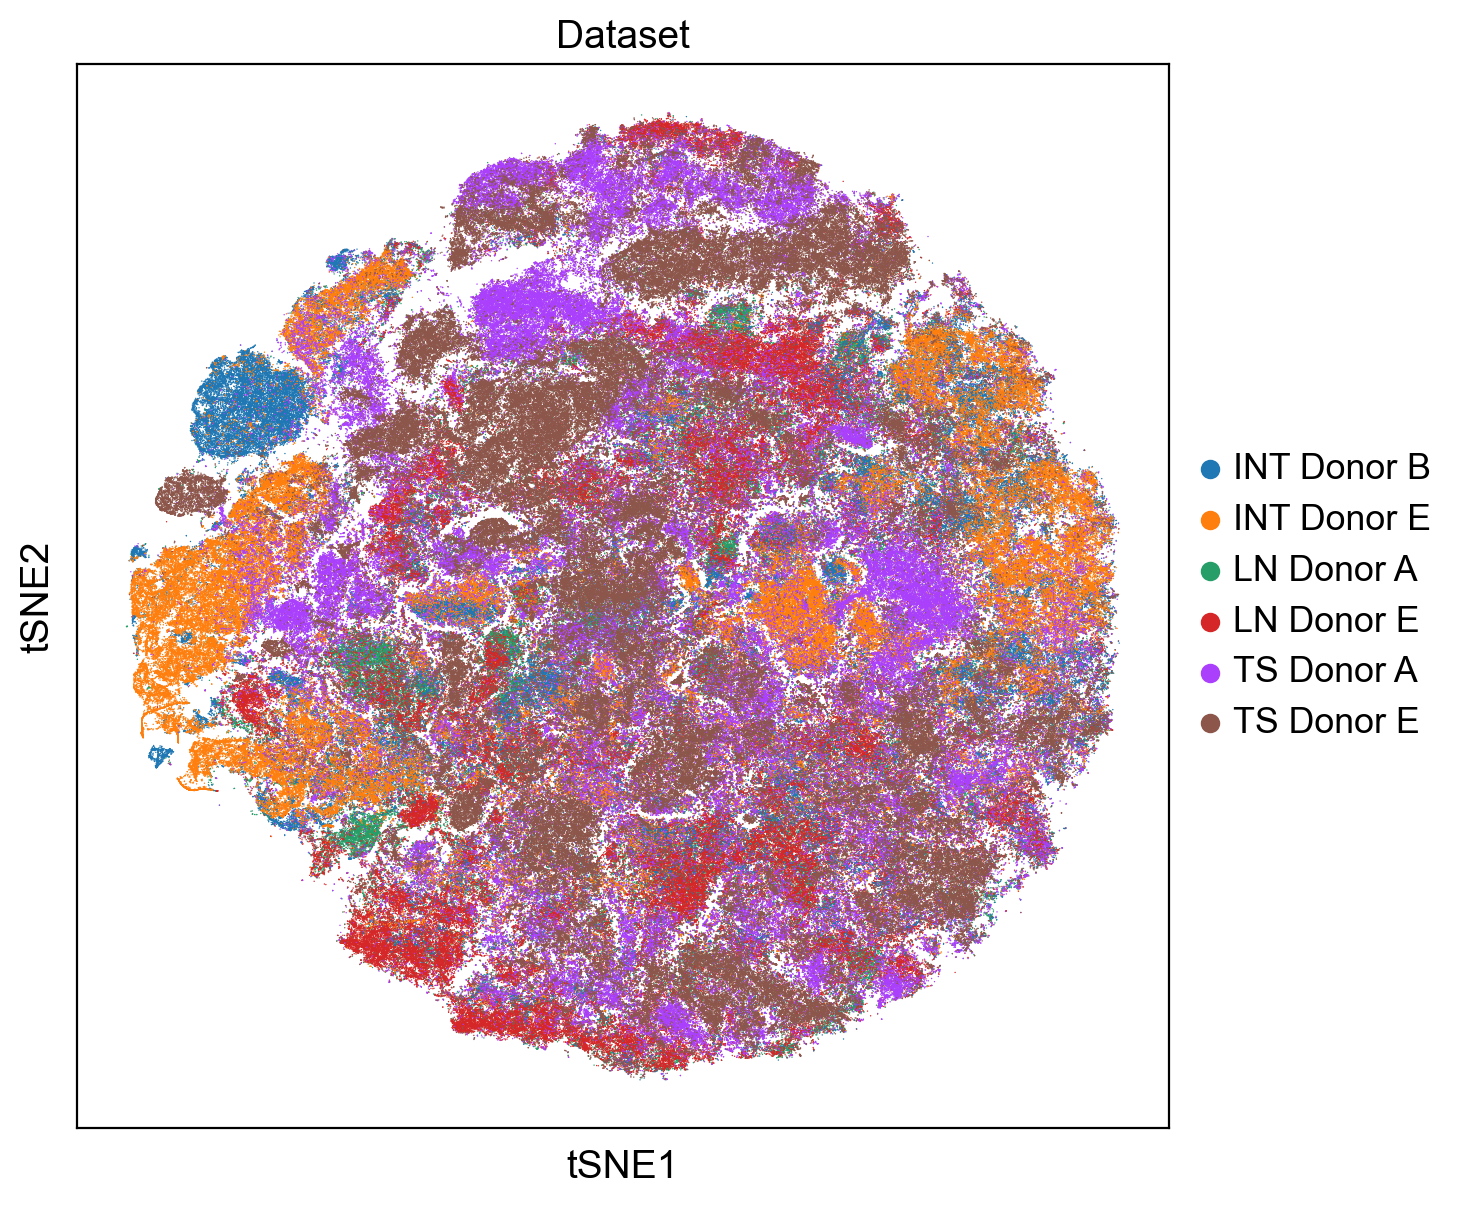

In [32]:
sc.set_figure_params(format='png')

with rc_context({'figure.figsize': (7, 7), 'figure.dpi': 100}):
    fig = sc.pl.tsne(adata, color=['Dataset'], size=1)

In [33]:
adata.write(adata_path)

In [34]:
adata

AnnData object with n_obs × n_vars = 999970 × 17
    obs: 'ROI', 'Cell', 'Dataset'
    uns: 'neighbors', 'Dataset_colors'
    obsm: 'spatial', 'X_scanorama', 'X_tsne'
    obsp: 'distances', 'connectivities'

In [35]:
sc.tl.leiden(adata, resolution=2.0)

running Leiden clustering
    finished: found 44 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (4:04:21)


In [36]:
adata.write(adata_path)

# Plot cluster mean expression

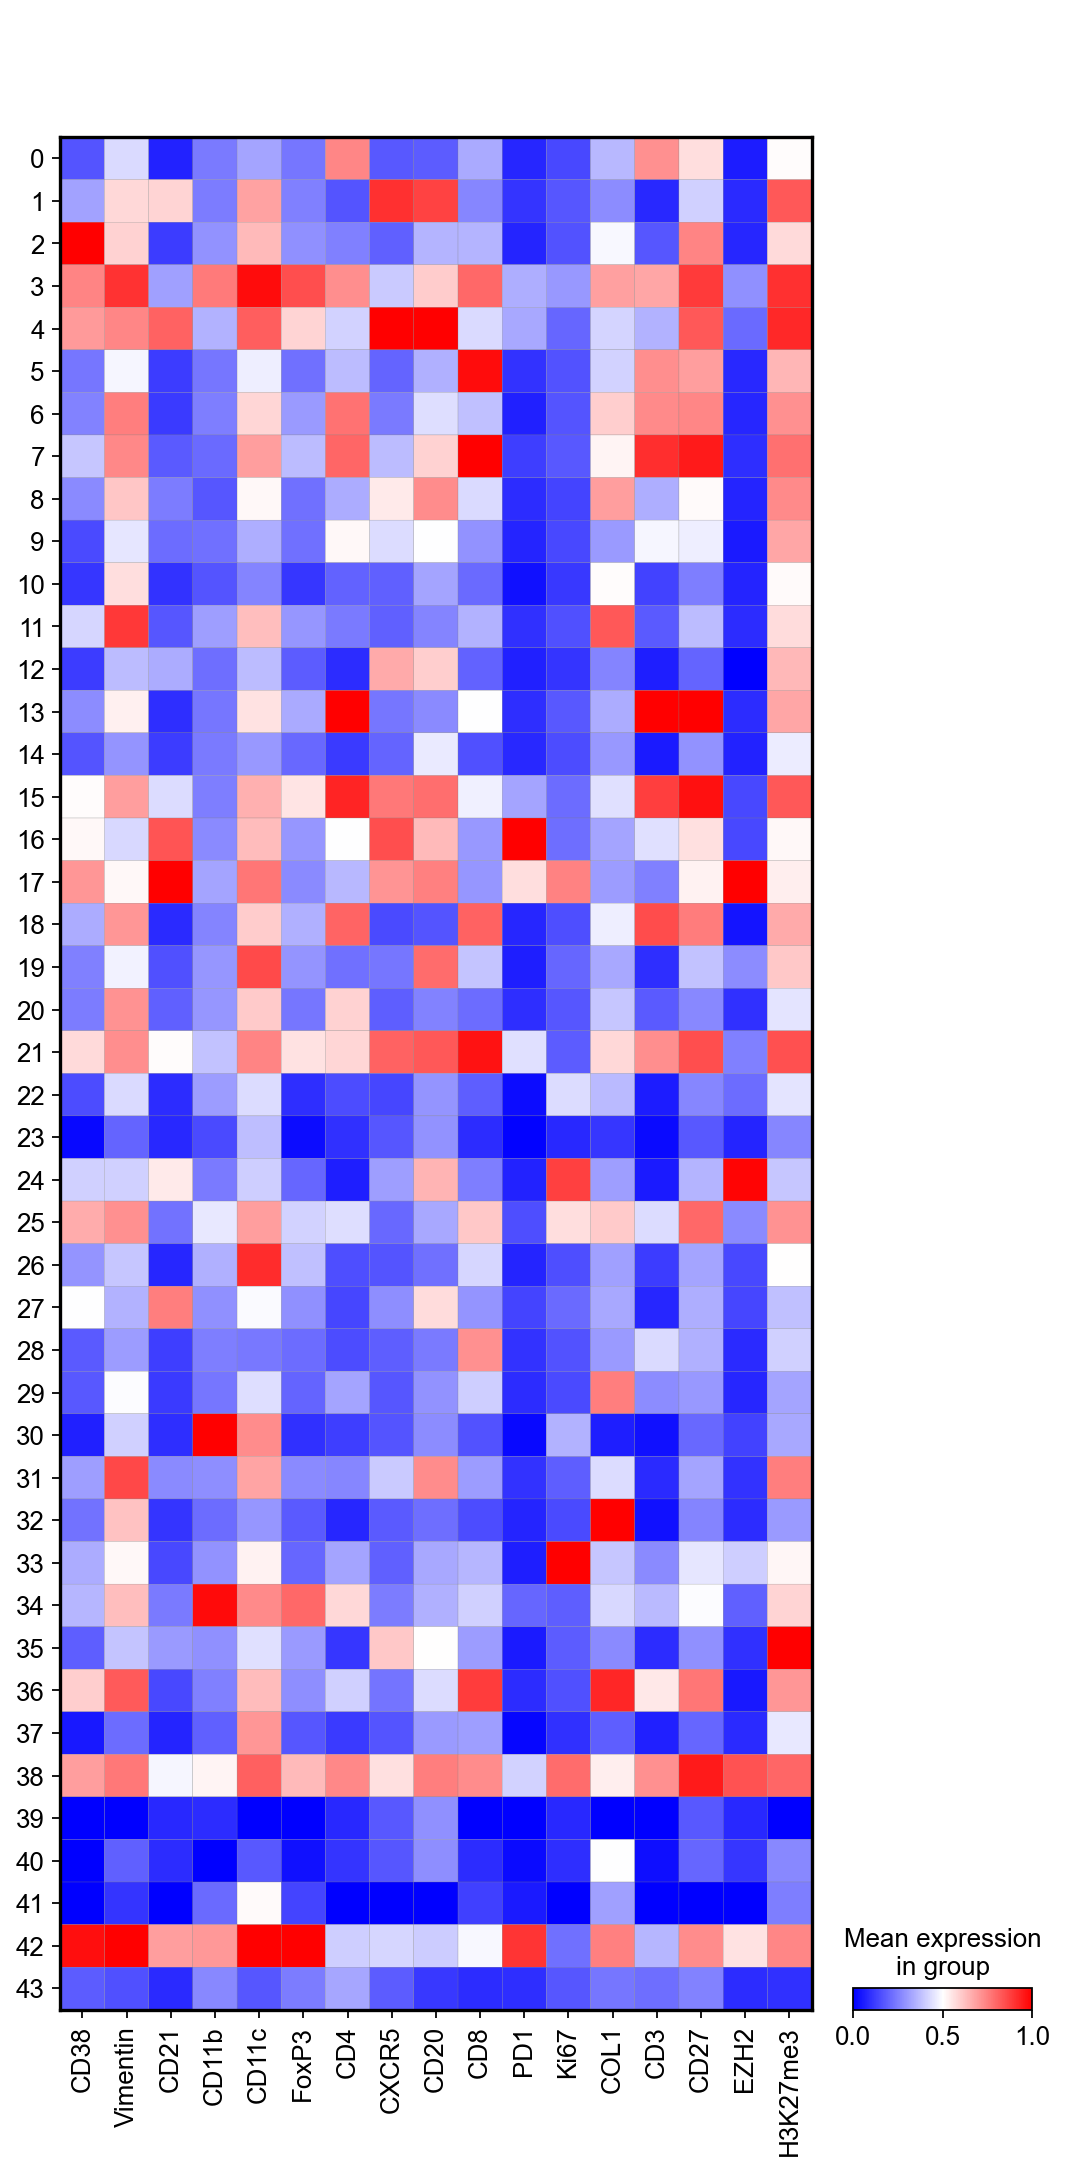

In [47]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='leiden', cmap='bwr',  dendrogram=False, standard_scale='var')

In [38]:
donors = adata.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata[adata.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['leiden'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [43]:
df = df.sort_index()

In [44]:
df.to_clipboard()